<a href="https://colab.research.google.com/github/Winindu/ML_CW/blob/master/Copy_of_telco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:


import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve,
    classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No  

/tmp/ipython-input-2141518832.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)


In [26]:
sns.set_style("whitegrid")
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


Load dataset


In [28]:

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Telco-Customer-Churn.csv")


 Basic cleaning

In [30]:
df.drop_duplicates(inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].replace(" ", np.nan), errors="coerce")
df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)

if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)

/tmp/ipython-input-3187732550.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)


EDA


=== Dataset Shape ===
(7043, 20)

=== First 5 Rows ===


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



=== Data Types ===
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

=== Summary Statistics (Numerical) ===


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000



=== Summary Statistics (Categorical) ===


,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


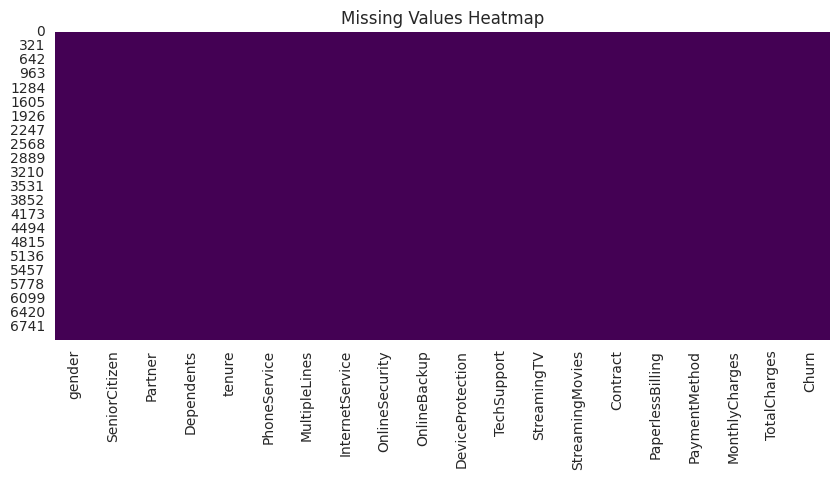

/tmp/ipython-input-2787473771.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Churn", palette="coolwarm")


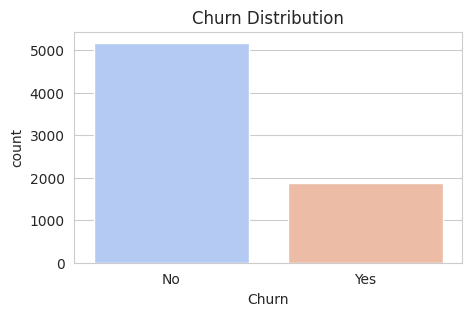

/tmp/ipython-input-2787473771.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")



Churn Rate (%):
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


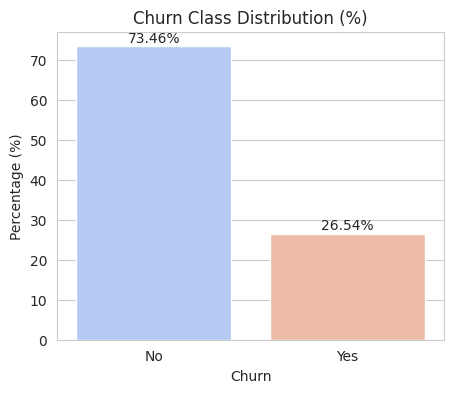

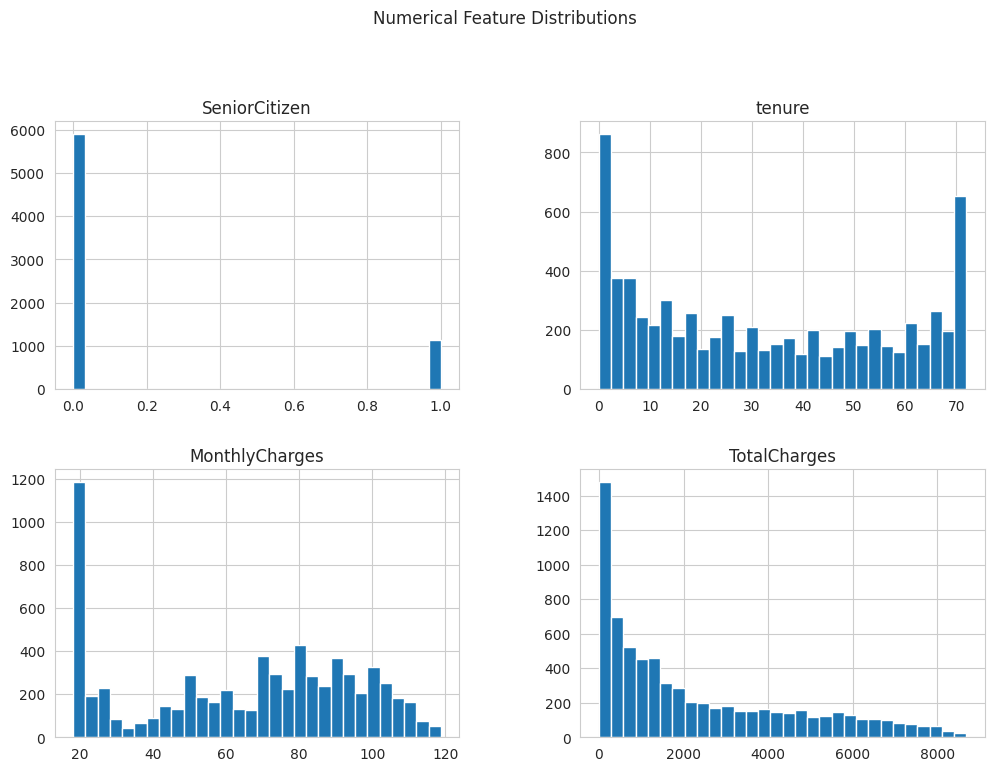

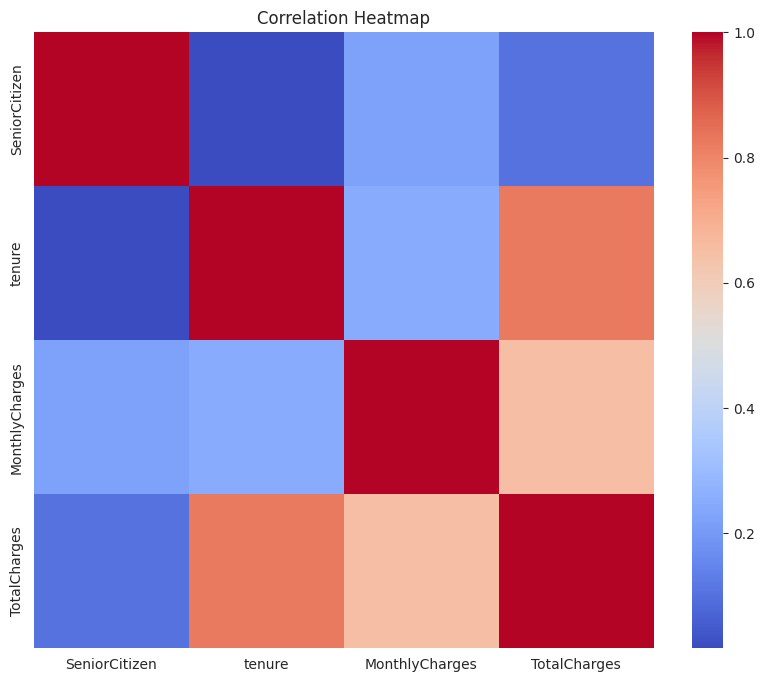

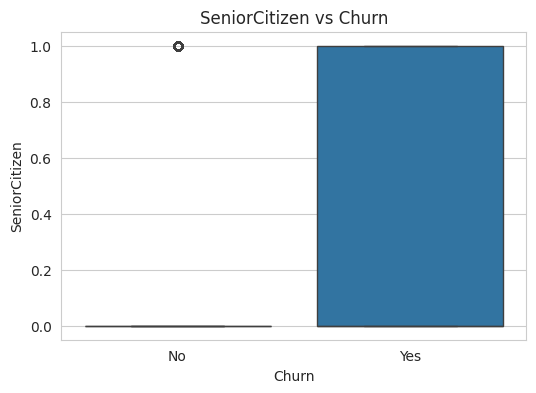

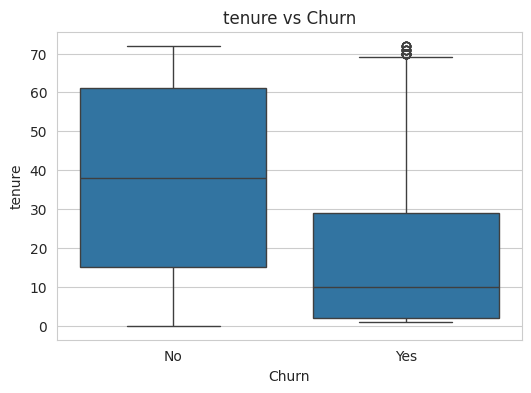

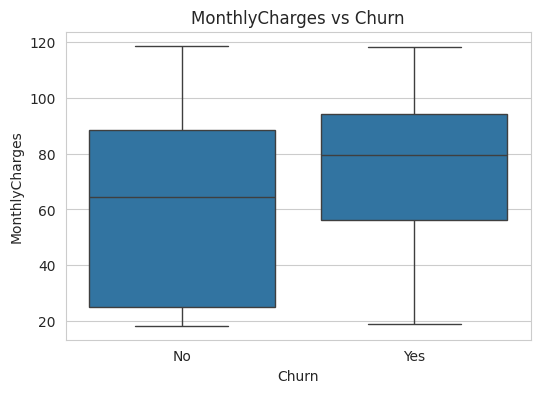

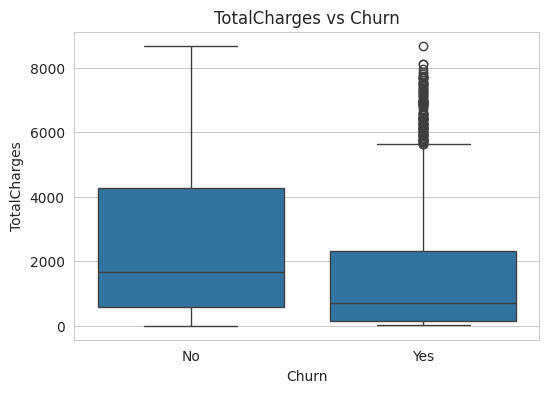

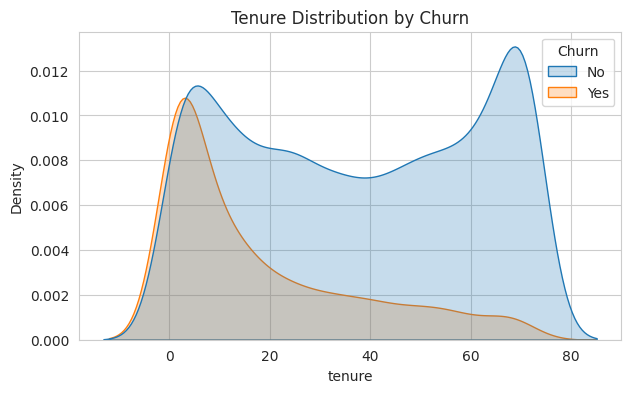

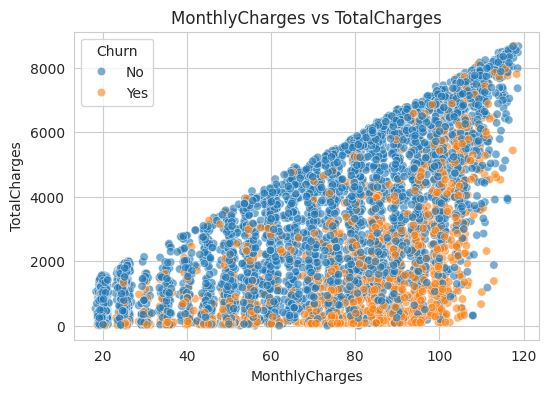

In [31]:
print("\n=== Dataset Shape ===")
print(df.shape)

print("\n=== First 5 Rows ===")
display(df.head())

print("\n=== Data Types ===")
print(df.dtypes)

print("\n=== Summary Statistics (Numerical) ===")
display(df.describe())

print("\n=== Summary Statistics (Categorical) ===")
display(df.describe(include=['object']))

# Missing values
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# Target distribution
plt.figure(figsize=(5,3))
sns.countplot(data=df, x="Churn", palette="coolwarm")
plt.title("Churn Distribution")
plt.show()

print("\nChurn Rate (%):")
print(df["Churn"].value_counts(normalize=True) * 100)

#class distribution
plt.figure(figsize=(5,4))
class_counts = df["Churn"].value_counts(normalize=True) * 100
sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")
plt.ylabel("Percentage (%)")
plt.title("Churn Class Distribution (%)")
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.show()

# Numerical distribution
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("Numerical Feature Distributions", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Churn vs numerical features
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Churn", y=col)
    plt.title(f"{col} vs Churn")
    plt.show()

# Tenure vs churn
plt.figure(figsize=(7,4))
sns.kdeplot(data=df, x="tenure", hue="Churn", fill=True)
plt.title("Tenure Distribution by Churn")
plt.show()

# Charges relationship
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="MonthlyCharges", y="TotalCharges", hue="Churn", alpha=0.6)
plt.title("MonthlyCharges vs TotalCharges")
plt.show()

Preprocessing

In [32]:
y = df["Churn"].map({"No":0, "Yes":1})
X = df.drop(columns=["Churn"])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe)
    ]), cat_cols)
])

train  test split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)


smote for decision tree

In [35]:
sm = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = sm.fit_resample(X_train_prep, y_train)
print("Balanced classes:", np.bincount(y_train_bal))

Balanced classes: [4139 4139]


Decision tree

In [36]:
dt = DecisionTreeClassifier(
    random_state=SEED,
    max_depth=4,
    min_samples_leaf=20
)

param_grid = {"min_samples_split": [10, 20, 30]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid_dt = GridSearchCV(dt, param_grid, cv=cv, scoring="f1")
grid_dt.fit(X_train_bal, y_train_bal)
best_dt = grid_dt.best_estimator_

# Evaluation
dt_pred = best_dt.predict(X_test_prep)
dt_proba = best_dt.predict_proba(X_test_prep)[:,1]

dt_train_pred = best_dt.predict(X_train_bal)
dt_train_acc = accuracy_score(y_train_bal, dt_train_pred)
dt_test_acc = accuracy_score(y_test, dt_pred)
dt_train_f1 = f1_score(y_train_bal, dt_train_pred)
dt_test_f1 = f1_score(y_test, dt_pred)

print("\n=== DECISION TREE ACCURACY GAP ===")
print(dt_train_acc, dt_test_acc, dt_train_acc - dt_test_acc)

print("\n=== DECISION TREE REPORT ===")
print(classification_report(y_test, dt_pred))
print("AUC:", roc_auc_score(y_test, dt_proba))

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_proba)



=== DECISION TREE ACCURACY GAP ===
0.7750664411693646 0.7324343506032647 0.042632090566099956

=== DECISION TREE REPORT ===
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1035
           1       0.50      0.74      0.60       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.78      0.73      0.75      1409

AUC: 0.8013691906275027


confusion matrix for decision tree

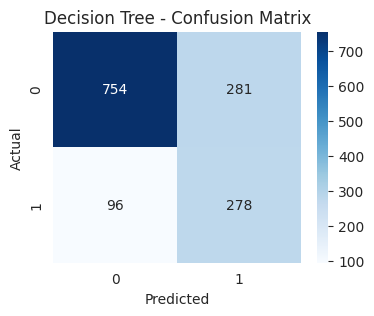

In [37]:
cm_dt = confusion_matrix(y_test, dt_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


 NEURAL NETWORK — HYPERPARAMETER SEARCH

In [38]:
input_dim = X_train_prep.shape[1]

In [39]:
def build_nn(n1, n2, lr, d1, d2):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(n1, activation="relu"),
        layers.Dropout(d1),
        layers.Dense(n2, activation="relu"),
        layers.Dropout(d2),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model



In [40]:
param_grid_nn = {
    "n1": [16, 32],
    "n2": [8, 16],
    "lr": [0.001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [20, 35],
    "dropout1": [0.3, 0.4],
    "dropout2": [0.2, 0.3]
}


In [41]:
best_f1 = -1
best_model = None
best_params = None

es = EarlyStopping(patience=5, restore_best_weights=True)


In [42]:
classes = np.unique(y_train)
class_weights_array = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes, class_weights_array))
print("Class Weights:", class_weight)

Class Weights: {np.int64(0): np.float64(0.6805991785455424), np.int64(1): np.float64(1.8842809364548494)}


In [ ]:
print("\n=== ANN SEARCH ===")

for n1 in param_grid_nn["n1"]:
    for n2 in param_grid_nn["n2"]:
        for lr in param_grid_nn["lr"]:
            for batch in param_grid_nn["batch_size"]:
                for ep in param_grid_nn["epochs"]:
                    for d1 in param_grid_nn["dropout1"]:
                        for d2 in param_grid_nn["dropout2"]:

                            model = build_nn(n1, n2, lr, d1, d2)
                            model.fit(X_train_prep, y_train,
                                      validation_split=0.2,
                                      epochs=ep,
                                      batch_size=batch,
                                      callbacks=[es],
                                      verbose=0,
                                      class_weight=class_weight )

                            pred = (model.predict(X_test_prep).ravel() >= 0.5).astype(int)
                            f1 = f1_score(y_test, pred)

                            print(f"F1={f1:.4f} | n1={n1} n2={n2} lr={lr}")

                            if f1 > best_f1:
                                best_f1 = f1
                                best_model = model
                                best_params = (n1, n2, lr, batch, ep, d1, d2)

print("\n=== BEST ANN PARAMETERS ===", best_params)
print("Best F1:", best_f1)



=== ANN SEARCH ===
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6109 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6102 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6195 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1=0.6144 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6172 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6157 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6131 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6120 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
F1=0.6093 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6154 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6190 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1=0.6132 | n1=16 n2=8 lr=0.001


FINAL ANN EVALUATION (BEST MODEL ONLY)

In [ ]:

train_proba = best_model.predict(X_train_prep).ravel()
test_proba  = best_model.predict(X_test_prep).ravel()

nn_train_pred = (train_proba >= 0.5).astype(int)
nn_pred       = (test_proba  >= 0.5).astype(int)

nn_train_acc = accuracy_score(y_train, nn_train_pred)
nn_test_acc  = accuracy_score(y_test, nn_pred)
nn_train_f1  = f1_score(y_train, nn_train_pred)
nn_test_f1   = f1_score(y_test, nn_pred)

fpr_nn, tpr_nn, _ = roc_curve(y_test, test_proba)

print("\n=== BEST NN ACCURACY GAP ===")
print(nn_train_acc, nn_test_acc, nn_train_acc - nn_test_acc)

print("\n=== BEST NN REPORT ===")
print(classification_report(y_test, nn_pred))
print("AUC:", roc_auc_score(y_test, test_proba))

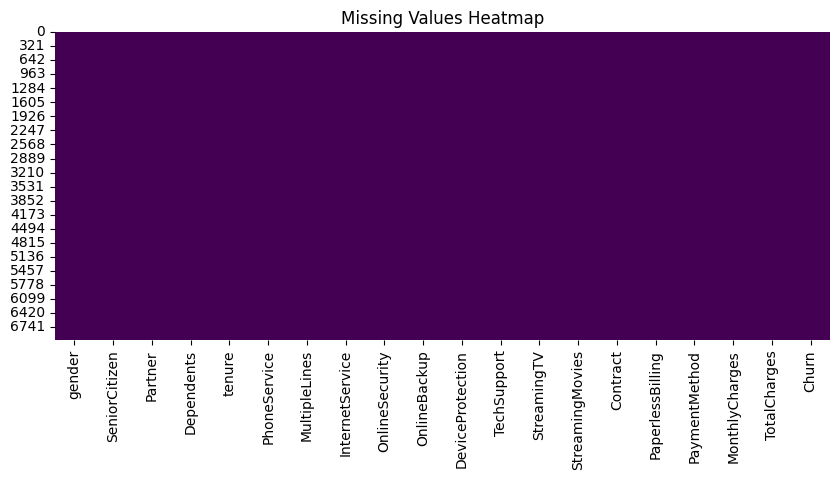

In [8]:
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


/tmp/ipython-input-1471804089.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Churn", palette="coolwarm")


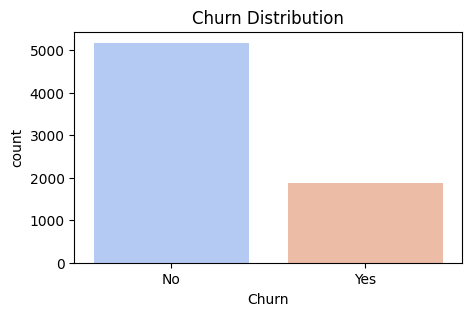

In [9]:
plt.figure(figsize=(5,3))
sns.countplot(data=df, x="Churn", palette="coolwarm")
plt.title("Churn Distribution")
plt.show()


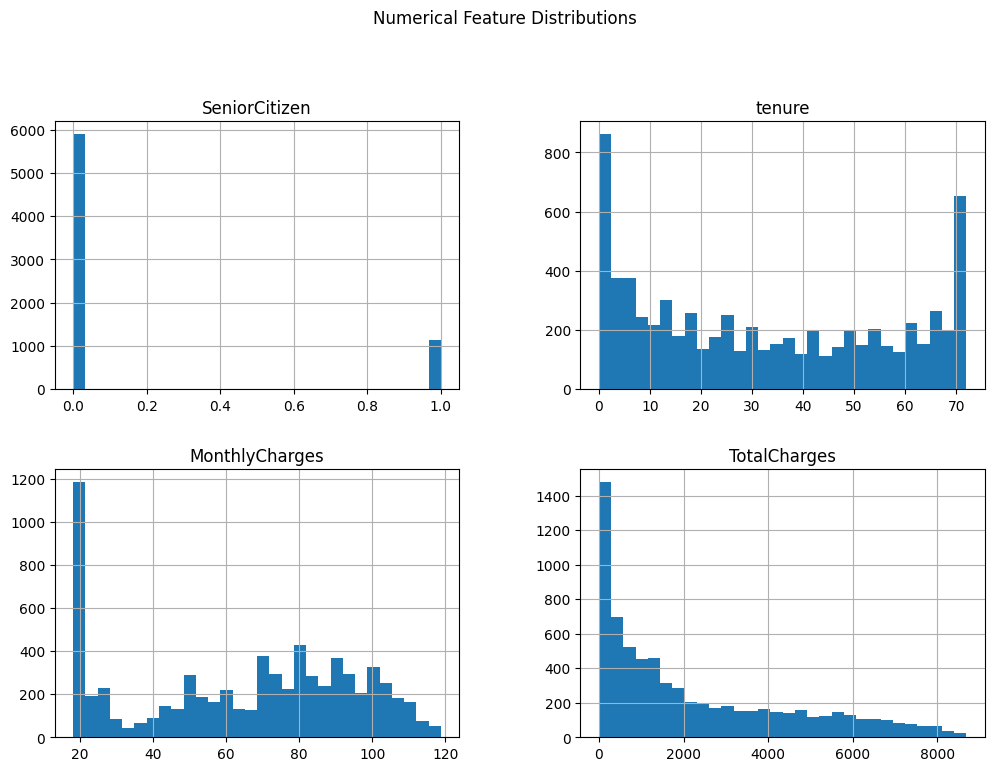

In [10]:
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("Numerical Feature Distributions", y=1.02)
plt.show()


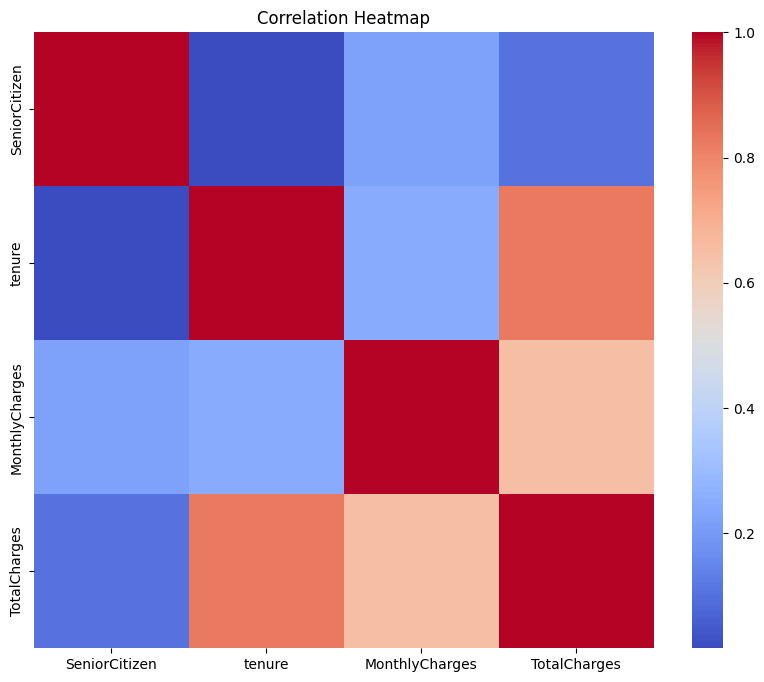

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


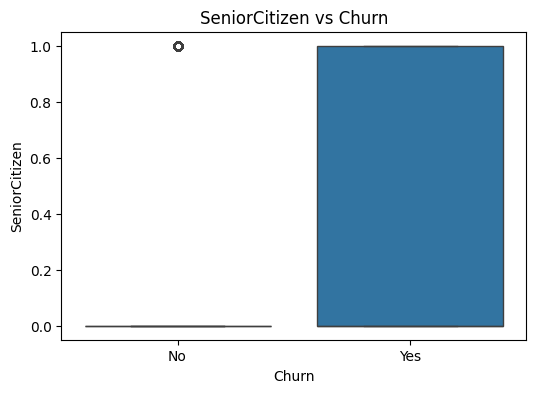

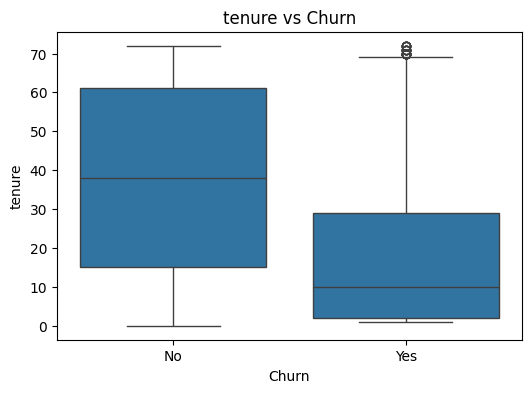

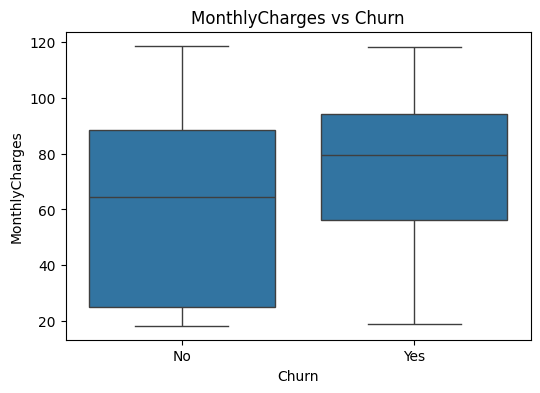

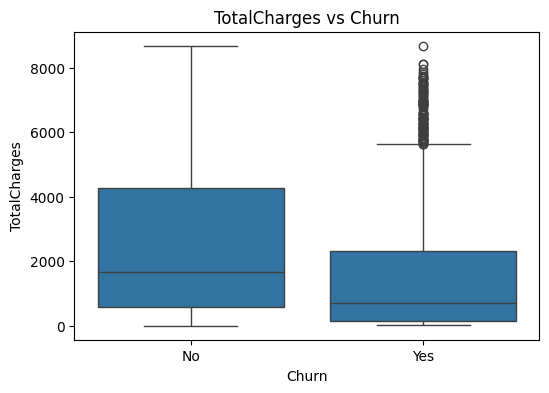

In [12]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Churn", y=col)
    plt.title(f"{col} vs Churn")
    plt.show()


In [13]:
y = df["Churn"].map({"No":0, "Yes":1})
X = df.drop(columns=["Churn"])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe)
    ]), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)


In [14]:
sm = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = sm.fit_resample(X_train_prep, y_train)
print("Balanced classes:", np.bincount(y_train_bal))


Balanced classes: [4139 4139]


In [15]:
dt = DecisionTreeClassifier(
    random_state=SEED,
    max_depth=4,
    min_samples_leaf=20
)

param_grid = {"min_samples_split": [10, 20, 30]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid_dt = GridSearchCV(dt, param_grid, cv=cv, scoring="f1")
grid_dt.fit(X_train_bal, y_train_bal)
best_dt = grid_dt.best_estimator_


In [16]:
dt_pred = best_dt.predict(X_test_prep)
dt_proba = best_dt.predict_proba(X_test_prep)[:,1]

print("\n=== DECISION TREE REPORT ===")
print(classification_report(y_test, dt_pred))
print("AUC:", roc_auc_score(y_test, dt_proba))



=== DECISION TREE REPORT ===
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1035
           1       0.50      0.74      0.60       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.78      0.73      0.75      1409

AUC: 0.8013691906275027


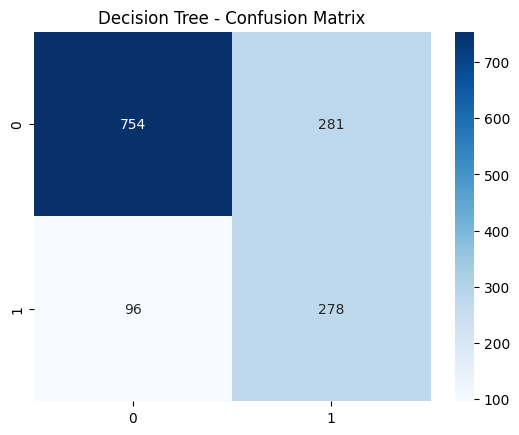

In [17]:
cm_dt = confusion_matrix(y_test, dt_pred)
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree - Confusion Matrix")
plt.show()


In [22]:
input_dim = X_train_prep.shape[1]

In [18]:
def build_nn(n1, n2, lr, d1, d2):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(n1, activation="relu"),
        layers.Dropout(d1),
        layers.Dense(n2, activation="relu"),
        layers.Dropout(d2),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model


In [20]:
param_grid_nn = {
    "n1": [16, 32],
    "n2": [8, 16],
    "lr": [0.001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [20, 35],
    "dropout1": [0.3, 0.4],
    "dropout2": [0.2, 0.3]
}

best_f1 = -1
best_model = None
best_params = None

es = EarlyStopping(patience=5, restore_best_weights=True)


In [24]:
classes = np.unique(y_train)
class_weights_array = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes, class_weights_array))
print("Class Weights:", class_weight)

Class Weights: {np.int64(0): np.float64(0.6805991785455424), np.int64(1): np.float64(1.8842809364548494)}


In [25]:

for n1 in param_grid_nn["n1"]:
    for n2 in param_grid_nn["n2"]:
        for lr in param_grid_nn["lr"]:
            for batch in param_grid_nn["batch_size"]:
                for ep in param_grid_nn["epochs"]:
                    for d1 in param_grid_nn["dropout1"]:
                        for d2 in param_grid_nn["dropout2"]:

                            model = build_nn(n1, n2, lr, d1, d2)
                            model.fit(X_train_prep, y_train,
                                      validation_split=0.2,
                                      epochs=ep,
                                      batch_size=batch,
                                      callbacks=[es],
                                      verbose=0,
                                      class_weight=class_weight )

                            pred = (model.predict(X_test_prep).ravel() >= 0.5).astype(int)
                            f1 = f1_score(y_test, pred)

                            print(f"F1={f1:.4f} | n1={n1} n2={n2} lr={lr}")

                            if f1 > best_f1:
                                best_f1 = f1
                                best_model = model
                                best_params = (n1, n2, lr, batch, ep, d1, d2)

print("\n=== BEST ANN PARAMETERS ===", best_params)
print("Best F1:", best_f1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6136 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6133 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1=0.6050 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6111 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1=0.6124 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1=0.6157 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1=0.6052 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1=0.6175 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1=0.6110 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1=0.6157 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6183 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6152 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6196 | n1=16 n2=8 lr=0.001
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1=0.6123 | n1=16 n2=8 lr=0.001
45/45 

KeyboardInterrupt: 

In [ ]:
train_proba = best_model.predict(X_train_prep).ravel()
test_proba  = best_model.predict(X_test_prep).ravel()

nn_train_pred = (train_proba >= 0.5).astype(int)
nn_pred       = (test_proba  >= 0.5).astype(int)

print("\n=== BEST NN REPORT ===")
print(classification_report(y_test, nn_pred))
print("AUC:", roc_auc_score(y_test, test_proba))


In [ ]:
cm_nn = confusion_matrix(y_test, nn_pred)
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Greens")
plt.title("Neural Network - Confusion Matrix")
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(fpr_dt, tpr_dt, label="Decision Tree")
plt.plot(fpr_nn, tpr_nn, label="Neural Network")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves")
plt.legend()
plt.show()


In [ ]:
summary = pd.DataFrame([
    ["Decision Tree", dt_train_acc, dt_test_acc, dt_train_acc - dt_test_acc, dt_train_f1, dt_test_f1],
    ["Neural Network", nn_train_acc, nn_test_acc, nn_train_acc - nn_test_acc, nn_train_f1, nn_test_f1]
], columns=["Model", "Train Acc", "Test Acc", "Gap", "Train F1", "Test F1"])

print(summary)
